In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
GAMMAS = ['1.0','0.9','0.8','0.7','0.6','0.5']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n11/"

def get_chance(gamma):
    if gamma == '1.0':
        return '100'
    elif gamma == '0.9':
        return '90'
    elif gamma == '0.8':
        return '80'
    elif gamma == '0.7':
        return '70'
    elif gamma == '0.6':
        return '60'
    elif gamma == '0.5':
        return '50'
    
def get_gamma_index(gamma):
    if gamma == '1.0':
        return 0
    elif gamma == '0.9':
        return 1
    elif gamma == '0.8':
        return 2
    elif gamma == '0.7':
        return 3
    elif gamma == '0.6':
        return 4
    elif gamma == '0.5':
        return 5
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in GAMMAS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in GAMMAS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in GAMMAS]
PLOT_X = [get_chance(p) + '%' for p in GAMMAS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))
#         print("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
#         .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in GAMMAS:
        runSketchTweets("SketchingTweet-v1_n11", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(GAMMAS)
    termfreq = [0] * len(GAMMAS)
    query_result = [0] * len(GAMMAS)
    query_similarity = [0] * len(GAMMAS)
    query_lookups = [0] * len(GAMMAS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_(\d+\.\d+)_s_([\.\d]+)_(.+).csv', file)  
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            gamma = filename.group(4)

            if name == "summary":    
                for p in GAMMAS:
                    if gamma == p:
                        summary[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in GAMMAS:
                    if gamma == p:
                        termfreq[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in GAMMAS:
                    if gamma == p:
                        query_result[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_similarity":
                for p in GAMMAS:
                    if gamma == p:
                        query_similarity[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in GAMMAS:
                    if gamma == p:
                        query_lookups[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                  
    
    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

In [6]:
results = run_expm1() 

# Process Results

In [7]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [8]:
summary = results['summary']
summary

,Summary_100%,Summary_90%,Summary_80%,Summary_70%,Summary_60%,Summary_50%
Run,1,1,1,1,1,1
Chance,100.0%,90.0%,80.0%,70.0%,60.0%,50.0%
Index time unit,1000,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,21890,21890,21890,21890,21890,21890
Indexed tweet counts,197610,197610,197610,197610,197610,197610
Index size,215201,192131,172053,151263,130018,108802


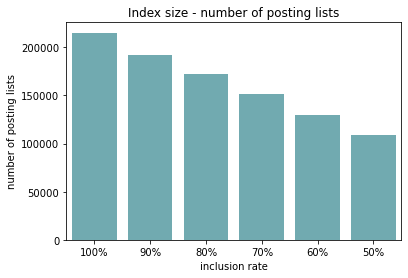

Summary_100%    215201
Summary_90%     192131
Summary_80%     172053
Summary_70%     151263
Summary_60%     130018
Summary_50%     108802
Name: Index size, dtype: object

In [9]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

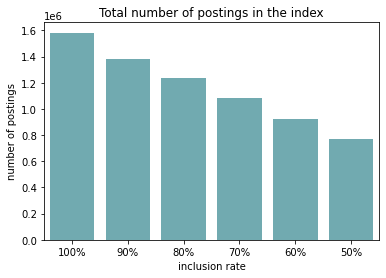

Total number of postings:


[1582263, 1383742, 1239801, 1082678, 923492, 767469]

In [10]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

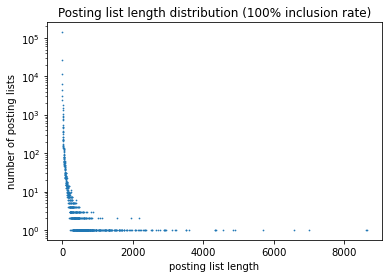

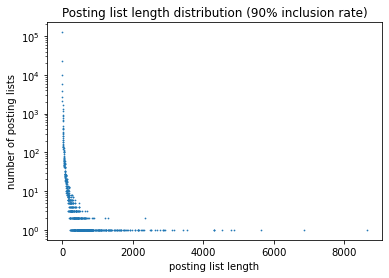

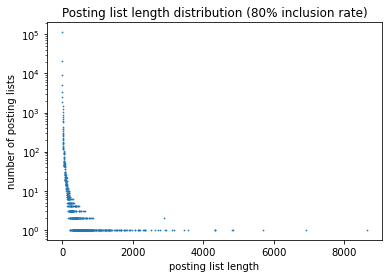

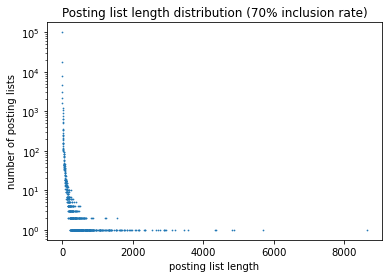

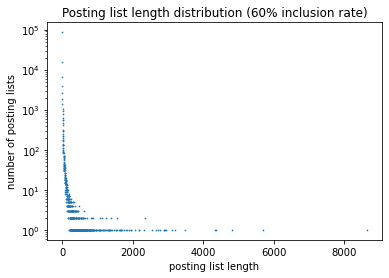

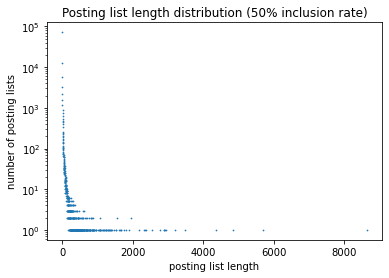

In [11]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[7.352489068359348, 7.202075667122952, 7.2059249184844205, 7.157586455379041, 7.102801150609915, 7.053813349019319]


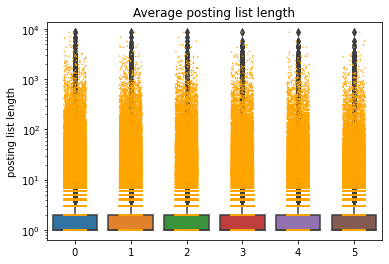

In [12]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.70000,0.70000,0.75000,0.66667,0.60000,5137,4630,4670,3416,1440,640
1,146028,146028,146028,146028,197559,191639,0.50000,0.50000,0.50000,0.66667,0.50000,1.00000,6516,4308,4324,3243,2,1
2,-1,-1,-1,145908,145908,145908,0.00000,0.00000,0.00000,0.50000,0.60000,0.50000,-1,-1,-1,1602,1320,180
3,-1,-1,-1,-1,-1,185838,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,-1,2
4,-1,-1,-1,-1,-1,157608,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,196841,196841,0.00000,0.00000,0.00000,0.00000,0.50000,0.50000,-1,-1,-1,-1,2,2
21886,-1,-1,-1,-1,-1,-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1,-1,-1,-1,-1,-1
21887,-1,-1,-1,-1,-1,197608,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,-1,2
21888,-1,-1,-1,-1,-1,195394,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,-1,-1,-1,-1,-1,324


In [14]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.70000,0.70000,0.75000,0.66667,0.60000,5137,4630,4670,3416,1440,640
1,146028,146028,146028,146028,197559,191639,0.50000,0.50000,0.50000,0.66667,0.50000,1.00000,6516,4308,4324,3243,2,1
8,44802,44802,197071,197071,197071,197071,0.60000,0.60000,0.50000,0.50000,0.50000,0.66667,38975,38740,56,60,60,42
12,170152,193999,193999,197505,197505,197505,0.60000,0.50000,0.50000,0.50000,0.50000,0.50000,7605,360,360,2,2,2
15,102434,102434,187662,187662,187662,187662,0.50000,0.50000,0.50000,0.66667,0.66667,0.66667,10200,10086,328,219,219,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21881,93654,-1,-1,-1,93654,93654,0.53846,0.00000,0.00000,0.00000,0.60000,0.60000,81484,-1,-1,-1,56490,56500
21884,178680,178680,178680,178680,178680,178680,0.62500,0.71429,0.71429,0.66667,0.66667,0.66667,120,84,84,66,66,66


In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[7247, 5336, 4427, 3730, 2964, 2228]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 90% of terms, we can find 73.63% truly similar tweets
Using 80% of terms, we can find 61.09% truly similar tweets
Using 70% of terms, we can find 51.47% truly similar tweets
Using 60% of terms, we can find 40.9% truly similar tweets
Using 50% of terms, we can find 30.74% truly similar tweets


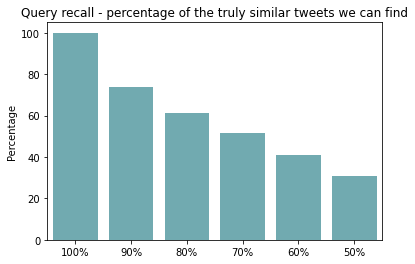

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [17]:
# is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
# predict_similar = query_result_similarity_lookup[is_predict_similar]
# num_predict_similar = predict_similar.shape[0]
# predict_similar
num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[7247, 8276, 9438, 10821, 12509, 14010]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 90% of terms, 64.48% tweets that we found similar are truly similar tweets
Using 80% of terms, 46.91% tweets that we found similar are truly similar tweets
Using 70% of terms, 34.47% tweets that we found similar are truly similar tweets
Using 60% of terms, 23.69% tweets that we found similar are truly similar tweets
Using 50% of terms, 15.9% tweets that we found similar are truly similar tweets


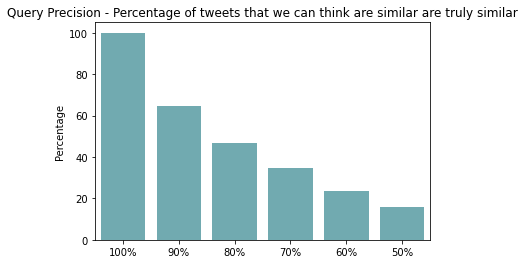

In [18]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [19]:
correct_search

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Similarity_100%,Similarity_90%,Similarity_80%,Similarity_70%,Similarity_60%,Similarity_50%,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%
0,189567,189567,189567,189567,189567,189567,0.63636,0.70000,0.70000,0.75000,0.66667,0.60000,5137,4630,4670,3416,1440,640
18,196085,196085,196085,197415,197415,196085,0.80000,0.80000,0.80000,0.50000,0.50000,0.66667,255,245,255,12,12,117
45,196644,196644,196644,196644,196644,196644,0.80000,0.66667,0.50000,0.50000,0.50000,0.50000,35,21,2,2,2,2
55,196844,196844,196844,196844,196844,196844,0.85714,0.72727,0.81818,0.80000,0.77778,0.71429,224,165,176,160,135,105
73,34300,34300,34300,34300,34300,34300,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,30897,20912,21072,21104,14392,14392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21878,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21880,197554,197554,197554,197554,197554,197554,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7,7,6,6,5,4
21881,93654,-1,-1,-1,93654,93654,0.53846,0.00000,0.00000,0.00000,0.60000,0.60000,81484,-1,-1,-1,56490,56500
21884,178680,178680,178680,178680,178680,178680,0.62500,0.71429,0.71429,0.66667,0.66667,0.66667,120,84,84,66,66,66


In [20]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 4923, 4123, 3531, 2826, 2177]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 90% of terms, 92.26% queries need less lookups before correctly finding the true similar tweets
Using 80% of terms, 93.13% queries need less lookups before correctly finding the true similar tweets
Using 70% of terms, 94.66% queries need less lookups before correctly finding the true similar tweets
Using 60% of terms, 95.34% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 97.71% queries need less lookups before correctly finding the true similar tweets


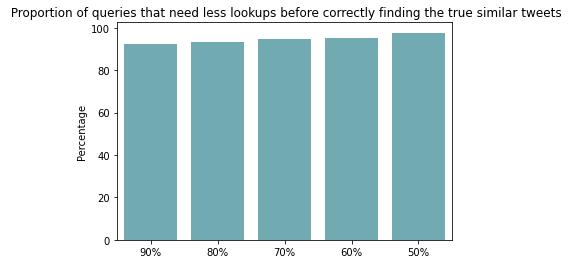

In [21]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

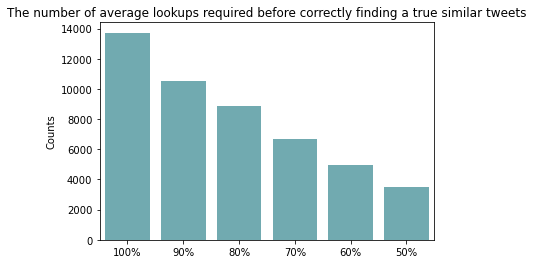

In [22]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [23]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% of less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 90% of terms, 23.46% of less lookups are needed for correctly finding a true similar tweets
By using 80% of terms, 35.48% of less lookups are needed for correctly finding a true similar tweets
By using 70% of terms, 51.26% of less lookups are needed for correctly finding a true similar tweets
By using 60% of terms, 63.68% of less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 74.69% of less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [24]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_90%,Index_time_run2_90%,Index_time_run3_90%,Index_time_run1_80%,Index_time_run2_80%,Index_time_run3_80%,Index_time_run1_70%,Index_time_run2_70%,Index_time_run3_70%,Index_time_run1_60%,Index_time_run2_60%,Index_time_run3_60%,Index_time_run1_50%,Index_time_run2_50%,Index_time_run3_50%
0,14.0218,10.6016,12.1306,23.1128,17.3218,18.4171,21.2479,16.6446,17.7922,17.6359,17.2813,22.4262,18.1371,23.8802,19.6270,18.1043,16.7408,18.0303
1,5.6190,5.1084,5.0711,11.5680,9.4939,9.0038,7.8991,5.8795,6.9694,6.9867,8.0861,8.0339,6.4290,6.5146,6.5786,7.4703,8.1333,6.7018
2,4.8529,5.2236,5.1395,10.7563,11.1409,7.5168,5.9027,5.7441,6.8108,7.4151,6.7074,9.2360,5.3843,9.3008,6.4658,7.1383,9.4000,6.9597
3,4.3292,3.8632,5.4982,12.2634,12.7970,6.6802,6.6069,5.5095,6.3578,5.9127,5.7169,9.0601,5.1296,7.6151,6.2658,6.4559,6.4912,6.6690
4,4.0958,4.9159,4.3176,11.8140,9.8922,7.1000,5.9223,5.8853,6.5201,6.0892,5.6040,9.4059,5.3701,7.3553,5.5146,6.1847,6.0647,9.1333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2.1167,2.7389,2.5354,3.6645,4.4240,4.4500,4.3831,3.9370,4.3386,3.2140,5.3249,3.3310,2.7326,3.4211,3.0043,12.9912,11.6688,2.9691
193,2.0811,2.6148,2.6750,4.0649,3.9955,4.4384,27.3275,4.1960,3.1768,3.1861,4.0402,3.2777,2.9909,3.2940,3.2313,3.1721,3.0106,2.9279
194,2.1338,2.6318,2.5158,4.7907,3.8974,4.1514,4.6362,3.6914,3.1957,3.2499,3.7482,3.2294,2.8016,3.3516,3.0881,3.0264,2.8322,3.0239
195,2.2760,2.6838,2.3567,3.9124,3.8361,4.1261,5.3863,3.3655,3.1587,3.2312,4.1032,3.0833,2.5804,3.2535,2.9549,2.7813,3.0224,2.8957


By using 100% of terms, the average time for indexing 1000 tweets is 3.1501 milliseconds
By using 90% of terms, the average time for indexing 1000 tweets is 5.0273 milliseconds
By using 80% of terms, the average time for indexing 1000 tweets is 4.1903 milliseconds
By using 70% of terms, the average time for indexing 1000 tweets is 4.22 milliseconds
By using 60% of terms, the average time for indexing 1000 tweets is 3.859 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 3.8488 milliseconds


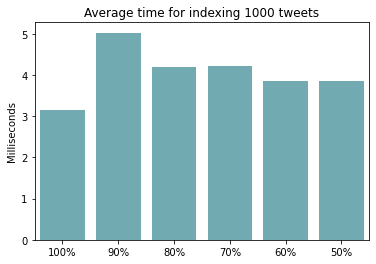

In [25]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [26]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_90%,Query_time_run2_90%,Query_time_run3_90%,Query_time_run1_80%,Query_time_run2_80%,Query_time_run3_80%,Query_time_run1_70%,Query_time_run2_70%,Query_time_run3_70%,Query_time_run1_60%,Query_time_run2_60%,Query_time_run3_60%,Query_time_run1_50%,Query_time_run2_50%,Query_time_run3_50%
0,2.2598,2.1150,2.9971,2.3539,2.4793,2.7145,2.7642,2.3660,2.1907,2.4849,3.1027,2.8817,2.5175,1.7586,1.6328,2.8985,2.5546,2.3109
1,284.3894,354.3850,314.4511,285.9027,326.0206,296.8240,231.3094,212.4150,248.2210,198.1790,213.0902,170.2450,149.6573,200.5764,151.9826,125.2394,158.3781,162.0359
2,199.3614,248.2690,228.7693,175.4049,163.0558,182.2045,116.7999,110.4522,125.3131,82.2059,87.0474,84.5081,62.0357,70.7578,62.8102,35.6698,61.4431,37.8760
3,207.8261,182.2730,191.0319,169.4813,200.2272,199.5228,127.6743,116.9790,127.6730,84.8933,97.1835,88.3803,64.5776,79.4591,70.1704,37.6775,39.1605,40.0296
4,214.6388,206.6052,196.6868,159.8645,177.2938,217.5347,121.9975,113.6788,127.1609,84.9324,90.3895,84.2199,62.5522,78.2294,64.3130,35.9872,36.5586,37.7317
5,202.1204,179.2127,185.3007,172.9466,169.6695,192.0145,120.0520,112.8953,121.4469,90.7116,105.5207,86.0992,62.1435,79.1399,65.8840,34.6994,36.3134,43.1205
6,212.7314,178.1346,190.9652,154.6993,169.6133,169.2598,121.3895,118.2837,123.3363,83.7659,175.6173,83.3676,63.0090,80.4401,66.7542,33.6337,40.0103,34.3808
7,227.1985,188.8453,196.3917,164.6578,172.6827,190.4046,121.9390,111.0038,126.5772,84.9927,124.0319,89.0420,69.7794,88.8188,78.6080,41.7951,45.1481,46.3659
8,211.0350,190.6895,194.9475,165.9461,169.4756,172.4935,119.3154,109.0875,122.7742,84.6111,111.4735,84.9324,60.5427,79.8144,69.4285,37.2216,38.5574,38.4072
9,197.5625,167.8504,178.7610,147.5795,160.4557,156.6151,106.6550,101.9491,119.0479,78.4570,100.8830,75.3398,61.8411,73.8363,65.9459,33.5200,38.3578,41.9605


By using 100% of terms, the average time for querying 1000 tweets is 183.4513 milliseconds
By using 90% of terms, the average time for querying 1000 tweets is 162.6927 milliseconds
By using 80% of terms, the average time for querying 1000 tweets is 114.033 milliseconds
By using 70% of terms, the average time for querying 1000 tweets is 87.838 milliseconds
By using 60% of terms, the average time for querying 1000 tweets is 69.0593 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 39.3807 milliseconds


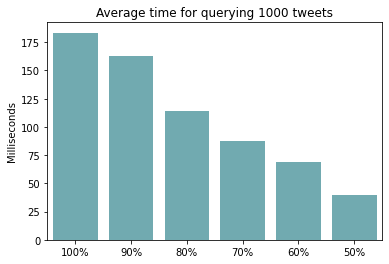

In [27]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))